In [1]:
"""
Impl of Value Iteration
"""
import random 
import numpy as np
import gym

In [24]:
import matplotlib.pyplot as plt

def frozen_lake(seed):
    """Defined in :numref:`sec_utils`"""
    # See https://www.gymlibrary.dev/environments/toy_text/frozen_lake/ to learn more about this env
    # How to process env.P.items is adpated from https://sites.google.com/view/deep-rl-bootcamp/labs
    env = gym.make('FrozenLake-v1', is_slippery=False)
    # env.seed(seed) # maybe the code is changed
    # env.action_space.np_random.seed(seed)
    # env.action_space.seed(seed)
    env.reset(seed=seed)
    env_info = {}
    env_info['desc'] = env.desc  # 2D array specifying what each grid item means
    env_info['num_states'] = 16  # Number of observations/states or obs/state dim
    env_info['num_actions'] = 4  # Number of actions or action dim
    # Define indices for (transition probability, nextstate, reward, done) tuple
    env_info['trans_prob_idx'] = 0  # Index of transition probability entry
    env_info['nextstate_idx'] = 1  # Index of next state entry
    env_info['reward_idx'] = 2  # Index of reward entry
    env_info['done_idx'] = 3  # Index of done entry
    env_info['mdp'] = {}
    env_info['env'] = env

    for (s, others) in env.P.items():
        # others(s) = {a0: [ (p(s'|s,a0), s', reward, done),...], a1:[...], ...}

        for (a, pxrds) in others.items():
            # pxrds is [(p1,next1,r1,d1),(p2,next2,r2,d2),..].
            # e.g. [(0.3, 0, 0, False), (0.3, 0, 0, False), (0.3, 4, 1, False)]
            env_info['mdp'][(s,a)] = pxrds

    return env_info

def make_env(name ='', seed=0):
    """Defined in :numref:`sec_utils`"""
    # Input parameters:
    # name: specifies a gym environment.
    # For Value iteration, only FrozenLake-v1 is supported.
    if name == 'FrozenLake-v1':
        return frozen_lake(seed)

    else:
        raise ValueError("%s env is not supported in this Notebook")

def show_Q_function_progress(env_desc, V_all, pi_all):
    """Defined in :numref:`sec_utils`"""
    # This function visualizes how value and policy changes over time.
    # V: [num_iters, num_states]
    # pi: [num_iters, num_states]

    # We want to only shows few values
    num_iters_all = V_all.shape[0]
    num_iters = num_iters_all // 10

    vis_indx = np.arange(0, num_iters_all, num_iters).tolist()
    vis_indx.append(num_iters_all - 1)
    V = np.zeros((len(vis_indx), V_all.shape[1]))
    pi = np.zeros((len(vis_indx), V_all.shape[1]))

    for c, i in enumerate(vis_indx):
        V[c]  = V_all[i]
        pi[c] = pi_all[i]

    num_iters = V.shape[0]
    fig, ax = plt.subplots(figsize=(15, 15))

    for k in range(V.shape[0]):
        plt.subplot(4, 4, k + 1)
        plt.imshow(V[k].reshape(4,4), cmap="bone")
        ax = plt.gca()
        ax.set_xticks(np.arange(0, 5)-.5, minor=True)
        ax.set_yticks(np.arange(0, 5)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        ax.set_yticks([])

        # LEFT action: 0, DOWN action: 1
        # RIGHT action: 2, UP action: 3
        action2dxdy = {0:(-.25, 0),1:(0, .25),
                       2:(0.25, 0),3:(-.25, 0)}

        for y in range(4):
            for x in range(4):
                action = pi[k].reshape(4,4)[y, x]
                dx, dy = action2dxdy[action]

                if env_desc[y,x].decode() == 'H':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="y",
                         size=20, fontweight='bold')

                elif env_desc[y,x].decode() == 'G':
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="w",
                         size=20, fontweight='bold')

                else:
                    ax.text(x, y, str(env_desc[y,x].decode()),
                       ha="center", va="center", color="g",
                         size=15, fontweight='bold')

                # No arrow for cells with G and H labels
                if env_desc[y,x].decode() != 'G' and env_desc[y,x].decode() != 'H':
                    ax.arrow(x, y, dx, dy, color='r', head_width=0.2, head_length=0.15)

        ax.set_title("Step = "  + str(vis_indx[k] + 1), fontsize=20)

    fig.tight_layout()
    plt.show()

In [25]:
seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 256  # Number of iterations
alpha   = 0.9  # Learing rate
epsilon = 0.9  # Epsilon in epsilion gready algorithm
random.seed(seed)  # Set the random seed
np.random.seed(seed)
env_info = make_env('FrozenLake-v1', seed=seed)

In [34]:
def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s,:])

def q_learning(env_info, gamma, num_iters, alpha, epsilon):
    env_desc = env_info['desc']  # 2D array specifying what each grid item means
    env = env_info['env']  # 2D array specifying what each grid item means
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']

    Q  = np.zeros((num_states, num_actions))
    V  = np.zeros((num_iters + 1, num_states))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        # Reset environment
        state, _ = env.reset(seed=seed)
        done = False
        while not done:
            # Select an action for a given state and acts in env based on selected action
            action = e_greedy(env, Q, state, epsilon)
            next_state, reward, t, done, _ = env.step(action)
            # print(action, type(action), Q[state][action])
            # Q-update:
            y = reward + gamma * np.max(Q[next_state,:])
            Q[state, action] = Q[state, action] + alpha * (y - Q[state, action])

            # Move to the next state
            state = next_state
        # Record max value and max action for visualization purpose only
        for s in range(num_states):
            V[k,s]  = np.max(Q[s,:])
            pi[k,s] = np.argmax(Q[s,:])
    show_Q_function_progress(env_desc, V[:-1], pi[:-1])

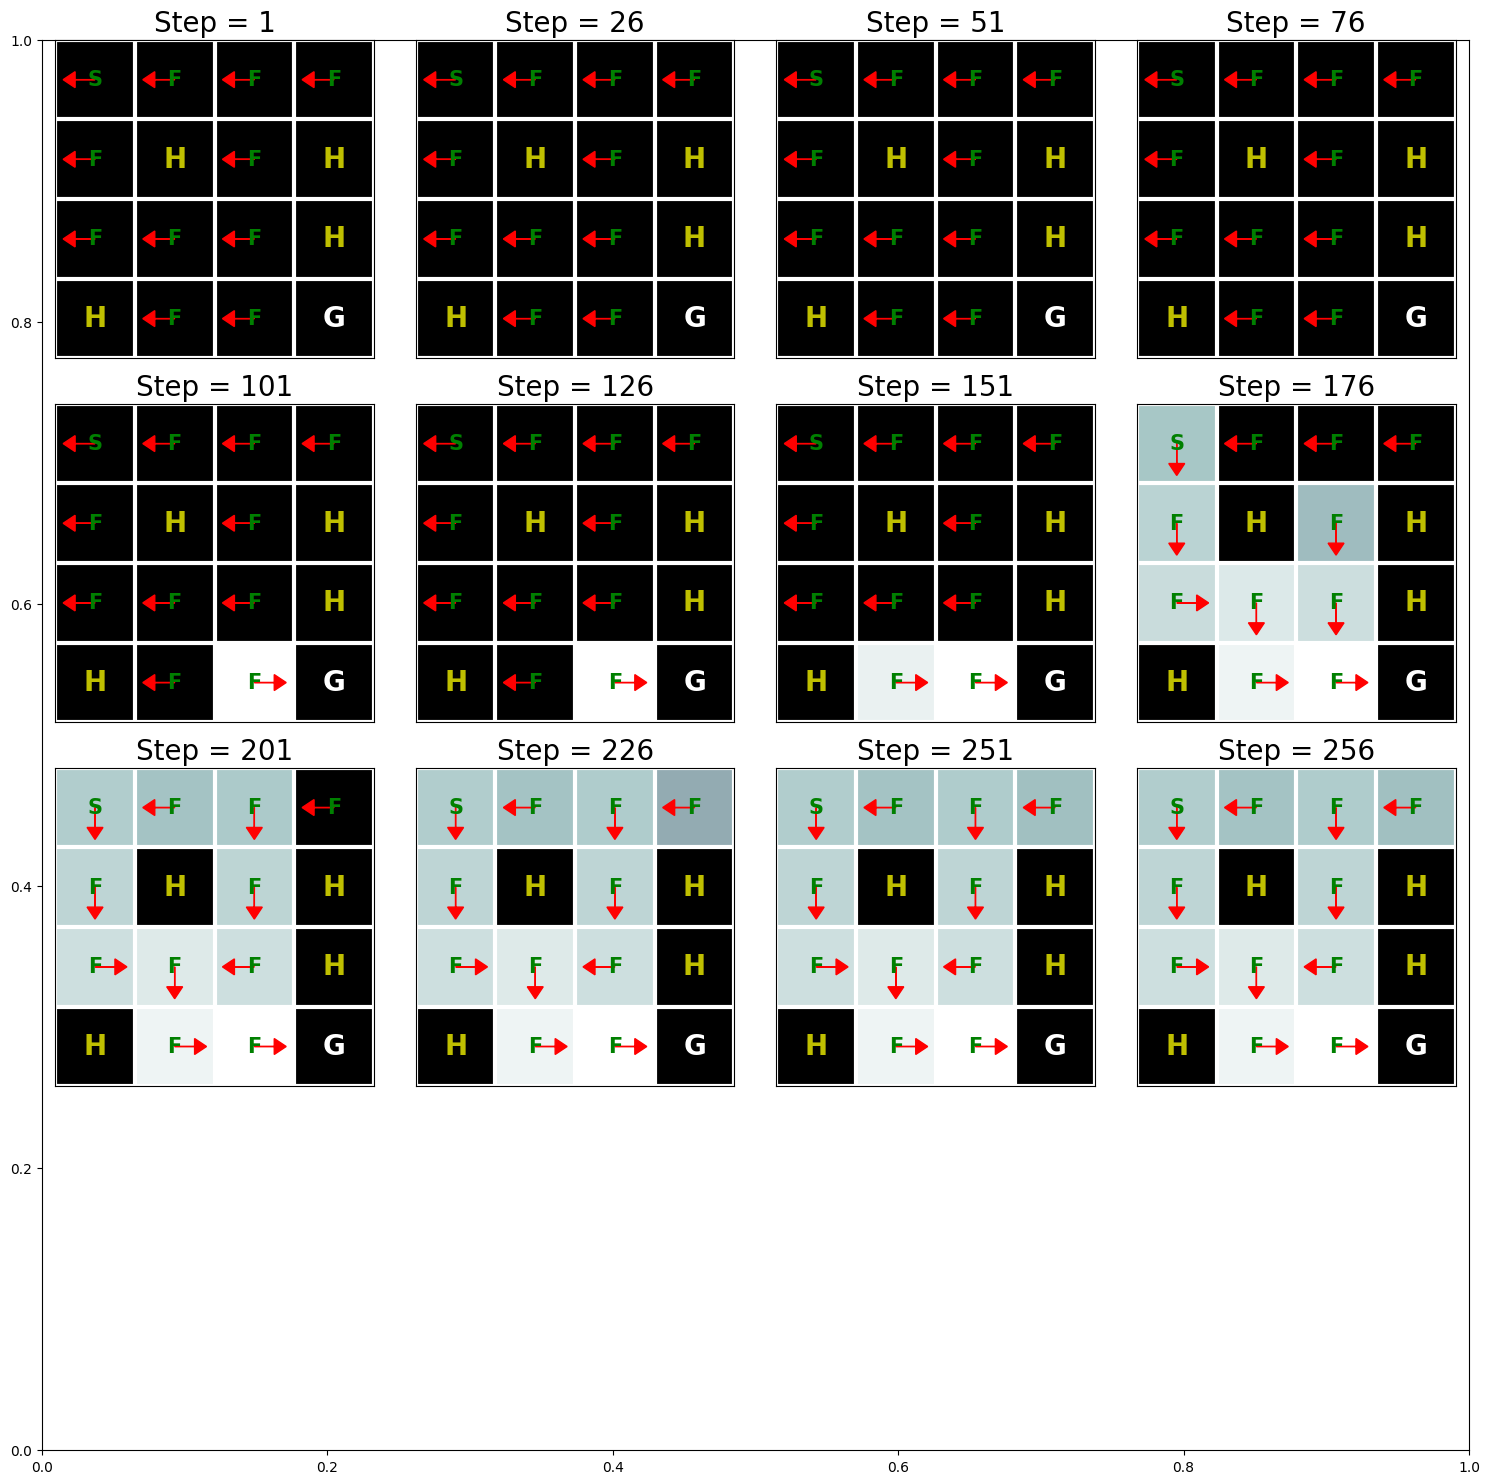

In [35]:
q_learning(env_info=env_info, gamma=gamma, num_iters=num_iters, alpha=alpha, epsilon=epsilon)